<a href="https://colab.research.google.com/github/zxyao5148/STAT3612_2023_1A_GroupProject/blob/main/RNN_Transformer/RNN_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates how to do timeseries classification using RNN models (Simple RNN, LSTM, and GRU).

Reference: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Load the dataset

In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split

# Raw URLs for the CSV files
train_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/train/train_valid_latest.csv"
test_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/test/test_latest.csv"

# Download the CSV files
train_csv = requests.get(train_url).text
test_csv = requests.get(test_url).text

# Read the CSV files into pandas DataFrames
train_valid = pd.read_csv(StringIO(train_csv))
test = pd.read_csv(StringIO(test_csv))

train_valid['deathtime'] = np.where(train_valid['deathtime'].notnull(), 1, 0)
test['deathtime'] = np.where(test['deathtime'].notnull(), 1, 0)

# with 80% of the data for training and 20% for validation
train, valid = train_test_split(train_valid, test_size=0.2, random_state=3612)

# Split the data into features (X) and target variable (y)
x_train = train[['deathtime']].join(train.iloc[:, 9:])
y_train = train.iloc[:, 8]

x_valid = valid[['deathtime']].join(valid.iloc[:, 9:])
y_valid = valid.iloc[:, 8]

x_test = test[['deathtime']].join(test.iloc[:,8:])

In [2]:
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_valid = x_valid.values.reshape((x_valid.shape[0], x_valid.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

# Reset the index of the y_train DataFrame
y_train = y_train.reset_index(drop=True)

# Shuffle the indices
idx = np.random.permutation(len(x_train))

# Reassign the values using the shuffled indices
x_train = x_train[idx]
y_train = y_train.iloc[idx]

## Build the model

The model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.


In [3]:
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Sequential
import keras

# Simple RNN

In [18]:
# Create a Sequential model
model = Sequential()

model.add(SimpleRNN(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(SimpleRNN(128, return_sequences=False, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

print('model compiled')

# Define early stopping callback
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

print(model.summary())

# Train the model with a smaller batch size
history_RNN = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_valid, y_valid), callbacks=callbacks)

model compiled
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 156, 64)           4224      
                                                                 
 dropout_6 (Dropout)         (None, 156, 64)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               24704     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 29057 (113.50 KB)
Trainable params: 29057 (113.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

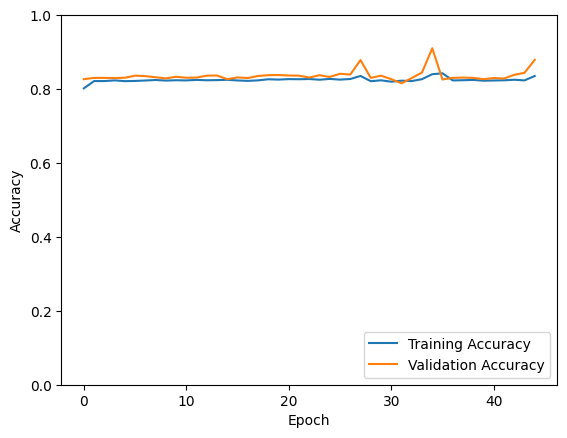

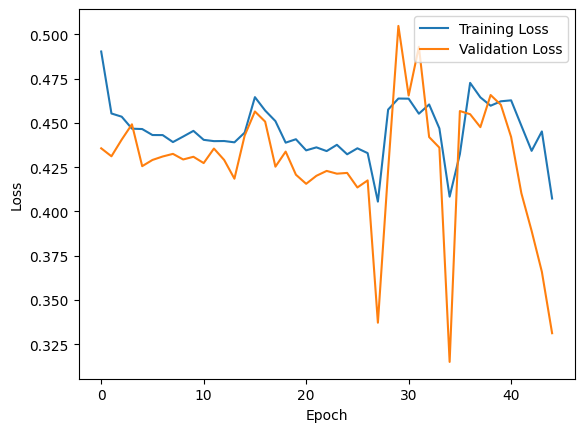

In [22]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_RNN.history['accuracy'], label='Training Accuracy')
plt.plot(history_RNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_RNN.history['loss'], label='Training Loss')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


##Evaluation

In [23]:
from sklearn.metrics import roc_auc_score

threshold = 0.5

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_valid_pred = model.predict(x_valid)
y_valid_pred_binary = (y_valid_pred > threshold).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_valid = accuracy_score(y_valid, y_valid_pred_binary)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (valid): {accuracy_valid:.4f}')
print(f'AUC (valid): {auc_valid:.4f}')

73/73 [==============================] - 2s 27ms/step
Accuracy (train): 0.9020
AUC (train): 0.8225
Accuracy (valid): 0.9103
AUC (valid): 0.8416


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_valid_pred_binary, zero_division=1)
recall = recall_score(y_valid, y_valid_pred_binary, zero_division=1)
f1 = f1_score(y_valid, y_valid_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For validation set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 0.9691
Recall: 0.4597
F1 Score: 0.6236 

For validation set:
Precision: 0.9559
Recall: 0.4949
F1 Score: 0.6522


In [25]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

92/92 [==============================] - 3s 34ms/step


In [26]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LSTM

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import keras

# Create a Sequential model
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False, activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

print('model compiled')

# Define early stopping callback
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

print(model.summary())

# Train the model with a smaller batch size
history_LSTM = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_valid, y_valid), callbacks=callbacks)

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 156, 64)           16896     
                                                                 
 dropout_4 (Dropout)         (None, 156, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 115841 (452.50 KB)
Trainable params: 115841 (452.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_LSTM.history['accuracy'], label='Training Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


##Evaluation

In [13]:
from sklearn.metrics import roc_auc_score

threshold = 0.5

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_valid_pred = model.predict(x_valid)
y_valid_pred_binary = (y_valid_pred > threshold).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_valid = accuracy_score(y_valid, y_valid_pred_binary)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (valid): {accuracy_valid:.4f}')
print(f'AUC (valid): {auc_valid:.4f}')

73/73 [==============================] - 1s 8ms/step
Accuracy (train): 0.9260
AUC (train): 0.8525
Accuracy (valid): 0.9341
AUC (valid): 0.8399


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_valid_pred_binary, zero_division=1)
recall = recall_score(y_valid, y_valid_pred_binary, zero_division=1)
f1 = f1_score(y_valid, y_valid_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For validation set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 0.9969
Recall: 0.583
F1 Score: 0.7357 

For validation set:
Precision: 0.9959
Recall: 0.6142
F1 Score: 0.7598


In [15]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

92/92 [==============================] - 1s 11ms/step


In [16]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  Bidirectional LSTM

In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
import keras
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
# Add a Bidirectional LSTM layer with return_sequences=True and L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1), kernel_regularizer=l2(0.01))))
# Add Batch Normalization
model.add(BatchNormalization())
model.add(Dropout(0.3))
# Add another Bidirectional LSTM layer with return_sequences=False and activation function set to "tanh"
model.add(Bidirectional(LSTM(128, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01))))
# Add Batch Normalization
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

# Compile the model with a lower learning rate and use ReduceLROnPlateau for learning rate scheduling
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

print('model compiled')

# Define early stopping and learning rate reduction callbacks
callbacks = [EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(factor=0.1, patience=5)]

# Print model summary
#print(model.summary())

# Train the model with a smaller batch size
history_LSTM = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=callbacks)

model compiled
Epoch 1/100
73/73 [==============================] - 18s 64ms/step - loss: 2.6069 - accuracy: 0.8408 - val_loss: 1.4208 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 3s 46ms/step - loss: 0.8089 - accuracy: 0.9217 - val_loss: 0.7743 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 3/100
73/73 [==============================] - 3s 42ms/step - loss: 0.4742 - accuracy: 0.9252 - val_loss: 0.5720 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 4/100
73/73 [==============================] - 3s 43ms/step - loss: 0.3609 - accuracy: 0.9269 - val_loss: 0.5172 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 5/100
73/73 [==============================] - 3s 41ms/step - loss: 0.3124 - accuracy: 0.9283 - val_loss: 0.4504 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 6/100
73/73 [==============================] - 3s 41ms/step - loss: 0.2919 - accuracy: 0.9271 - val_loss: 0.3971 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 7/100
73/73 [==============================] - 3

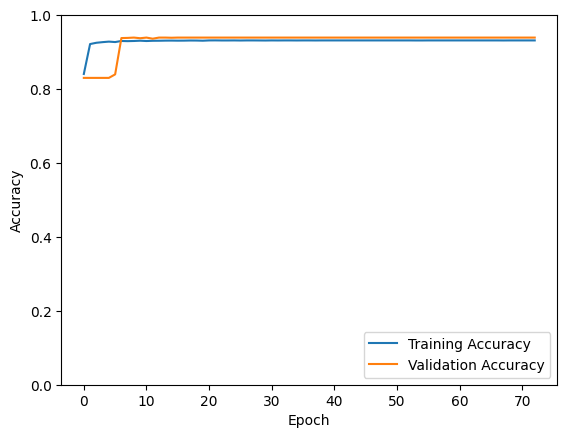

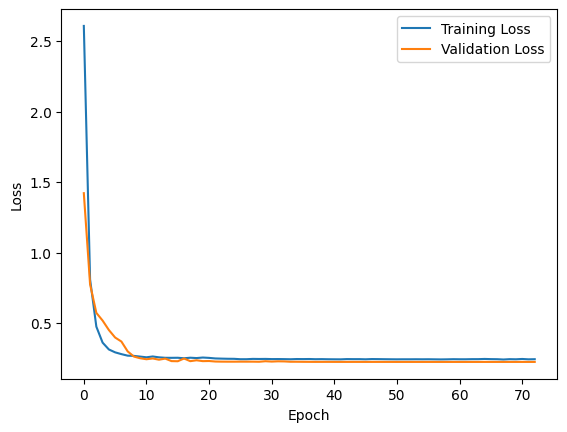

In [31]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_LSTM.history['accuracy'], label='Training Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


##Evaluation

In [32]:
from sklearn.metrics import roc_auc_score

threshold = 0.5

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_valid_pred = model.predict(x_valid)
y_valid_pred_binary = (y_valid_pred > threshold).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_valid = accuracy_score(y_valid, y_valid_pred_binary)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (valid): {accuracy_valid:.4f}')
print(f'AUC (valid): {auc_valid:.4f}')

73/73 [==============================] - 1s 14ms/step
Accuracy (train): 0.9315
AUC (train): 0.8518
Accuracy (valid): 0.9392
AUC (valid): 0.8532


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_valid_pred_binary, zero_division=1)
recall = recall_score(y_valid, y_valid_pred_binary, zero_division=1)
f1 = f1_score(y_valid, y_valid_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For validation set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 1.0
Recall: 0.6123
F1 Score: 0.7596 

For validation set:
Precision: 1.0
Recall: 0.6421
F1 Score: 0.7821


In [34]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

92/92 [==============================] - 1s 13ms/step


In [35]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# GRU

In [39]:
model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(64, return_sequences=False, activation='relu'))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(1, activation = "sigmoid"))

model_GRU.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

print('model compiled')

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

print(model_GRU.summary())

#Train the model
history_GRU=model_GRU.fit(x_train, y_train, batch_size=512, epochs=200, validation_data = (x_valid, y_valid), callbacks=callbacks)

model compiled
Epoch 1/100


KeyboardInterrupt: ignored

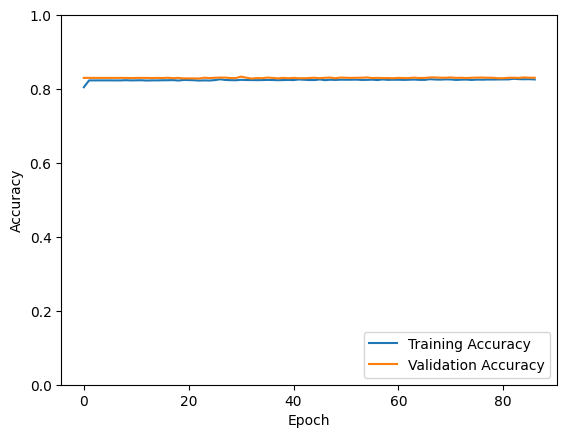

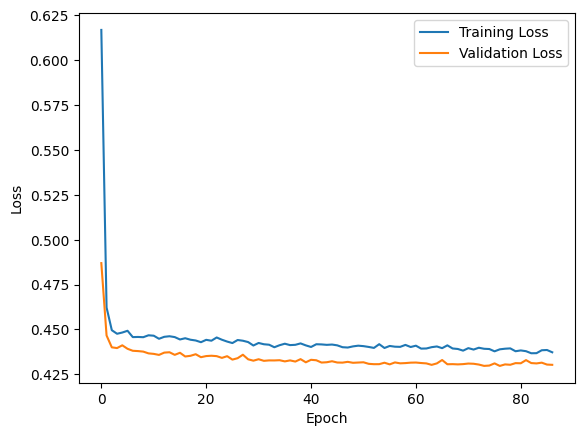

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_GRU.history['accuracy'], label='Training Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

##Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score

threshold = 0.5

y_train_pred = model_GRU.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_valid_pred = model_GRU.predict(x_valid)
y_valid_pred_binary = (y_valid_pred > threshold).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_valid = accuracy_score(y_valid, y_valid_pred_binary)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (valid): {accuracy_valid:.4f}')
print(f'AUC (valid): {auc_valid:.4f}')

NameError: ignored

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_valid_pred_binary, zero_division=1)
recall = recall_score(y_valid, y_valid_pred_binary, zero_division=1)
f1 = f1_score(y_valid, y_valid_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For validation set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 0.6667
Recall: 0.0366
F1 Score: 0.0694 

For validation set:
Precision: 0.5312
Recall: 0.0431
F1 Score: 0.0798


In [ ]:
y_test_pred = model_GRU.predict(x_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

92/92 [==============================] - 2s 26ms/step


In [ ]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Bidirectional GRU

In [49]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, Bidirectional
import keras
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create a Sequential model
model_GRU = Sequential()

# Add a Bidirectional GRU layer with return_sequences=True and dropout
model_GRU.add(Bidirectional(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1), dropout=0.2, recurrent_dropout=0.2)))

# Add Batch Normalization
model_GRU.add(BatchNormalization())

# Add another Bidirectional GRU layer with return_sequences=False and activation function set to "relu"
model_GRU.add(Bidirectional(GRU(64, return_sequences=False, activation='relu', dropout=0.2, recurrent_dropout=0.2)))

# Add Batch Normalization
model_GRU.add(BatchNormalization())

# Add a Dense output layer with sigmoid activation function
model_GRU.add(Dense(1, activation="sigmoid"))

# Compile the model with a lower learning rate and use ReduceLROnPlateau for learning rate scheduling
model_GRU.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

print('model compiled')

# Define early stopping and learning rate reduction callbacks
callbacks = [EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(factor=0.1, patience=5)]

# Print model summary
#print(model_GRU.summary())

# Train the model with a smaller batch size
history_GRU = model_GRU.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=callbacks)

model compiled
Epoch 1/100
73/73 [==============================] - 182s 2s/step - loss: 0.4308 - accuracy: 0.8331 - val_loss: 0.5004 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 2/100
73/73 [==============================] - 166s 2s/step - loss: 0.2723 - accuracy: 0.9236 - val_loss: 0.4547 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 3/100
25/73 [=========>....................] - ETA: 1:43 - loss: 0.2701 - accuracy: 0.9225

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_GRU.history['accuracy'], label='Training Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

##Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score

threshold = 0.5

y_train_pred = model_GRU.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_valid_pred = model_GRU.predict(x_valid)
y_valid_pred_binary = (y_valid_pred > threshold).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_valid = accuracy_score(y_valid, y_valid_pred_binary)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (valid): {accuracy_valid:.4f}')
print(f'AUC (valid): {auc_valid:.4f}')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_valid_pred_binary, zero_division=1)
recall = recall_score(y_valid, y_valid_pred_binary, zero_division=1)
f1 = f1_score(y_valid, y_valid_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For validation set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

In [ ]:
y_test_pred = model_GRU.predict(x_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

In [ ]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')